# 20 Algorithms Explorations 

### I pick 1,2,3,13,20  
### DBSCAN, Isolation forest, LOF, CBLOF, VAE  

## Algorithm 1: Density-based spatial clustering of applications with noise (DBSCAN)

### Make Area to find the point which is either not Core Point or Border Point  
Core point: A point with at least minPts points in its ε-neighborhood.  
Border point: A point that is not a core point but is within the ε-neighborhood of a core point.  
Noise point (outlier): A point that is neither a core point nor a border point; it does not belong to any cluster.  

Drawback: NOT GOOD FOR BIG DATASETS

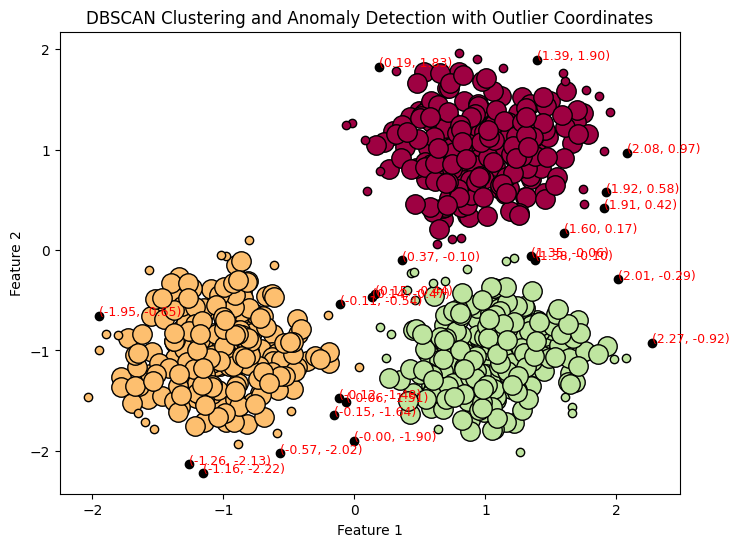

In [390]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_blobs

# Generate sample data using make_blobs
centers = [[1, 1], [-1, -1], [1, -1]]
X, _ = make_blobs(n_samples=750, centers=centers, cluster_std=0.4, random_state=0)

# Apply DBSCAN
dbscan = DBSCAN(eps=0.3, min_samples=10)
dbscan.fit(X)

# Extract labels (-1 represents noise points/outliers)
labels = dbscan.labels_

# Identify core samples (non-outliers)
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[dbscan.core_sample_indices_] = True

# Unique labels: -1 represents outliers, other integers represent cluster labels
unique_labels = set(labels)

# Plotting
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

plt.figure(figsize=(8, 6))

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black color for noise (outliers)
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    # Plot core points
    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    # Plot border points
    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

    # Show coordinates for outliers (label = -1)
    if k == -1:
        for x_coord, y_coord in zip(xy[:, 0], xy[:, 1]):
            plt.text(x_coord, y_coord, f"({x_coord:.2f}, {y_coord:.2f})", fontsize=9, color='red')

# Show plot with outlier coordinates
plt.title('DBSCAN Clustering and Anomaly Detection with Outlier Coordinates')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()


## Algorithm 2: Isolation Forest (Choice 1)

### Focus on split times and believe that the outlier will be split earlier  
1. Isolation as the Foundation: The central idea behind Isolation Forest is that anomalies (or outliers) are few and different from the majority of data points. This makes them easier to isolate. A data point that is different from others (an anomaly) will be isolated faster than a normal point.  
2. Tree-based Approach: Similar to decision trees, Isolation Forest splits the data recursively. The process of isolating a data point is done by randomly selecting a feature and then splitting it between the minimum and maximum values of that feature. The more "random splits" it takes to isolate a data point, the more likely that point is considered normal. Fewer splits mean the point is an anomaly.  
Normal points usually require more splits (deeper in the tree) to isolate them because they are more similar to other points.  
Anomalies require fewer splits (they are isolated quickly) because they are different from most other data points.  
3. How the Algorithm Works:  
Step 1: Build an Isolation Tree: The algorithm builds multiple random decision trees (hence the name "forest") where, at each node, a random feature and a random split value are chosen. This process recursively partitions the data until each data point is isolated in its own leaf node.  
Step 2: Isolation Path Length: The key observation is that the number of splits required to isolate a data point is shorter for outliers than for normal points. The path length (number of splits) for each point is calculated as it traverses through the tree.  
Step 3: Combine Trees: This process is repeated across multiple trees to reduce variance, and the average path length across all trees is computed for each data point.  
Step 4: Anomaly Score: The anomaly score for a data point is calculated based on the average path length. The shorter the average path length, the more likely the point is an outlier. The longer the average path length, the more likely it is a normal point.  
4. Random Sampling and Random Features split

DrawBack: Contaimination parameters, randomness

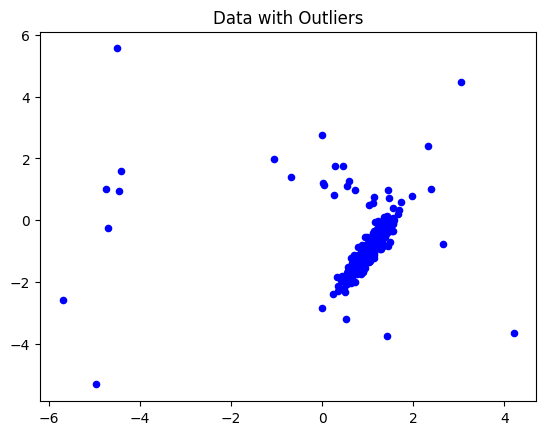

[1 1 1 1 1]


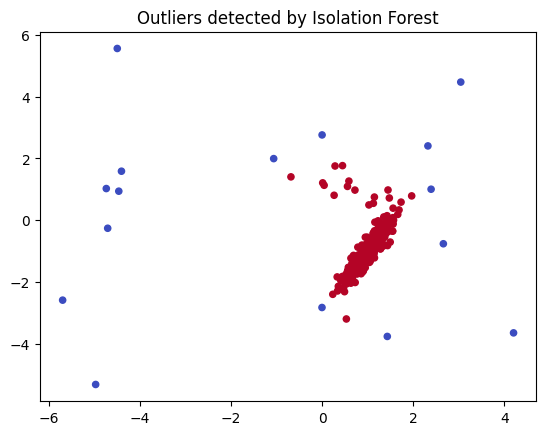

In [391]:
# Importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.datasets import make_classification

# Generate a synthetic dataset (binary classification) with outliers
X, _ = make_classification(n_samples=300, n_features=2, n_informative=2, n_redundant=0, 
                           n_clusters_per_class=1, weights=[0.95], flip_y=0, random_state=42)

# Add some random outliers
outliers = np.random.uniform(low=-6, high=6, size=(15, 2))
X = np.concatenate([X, outliers])

# Plot the initial data with outliers
plt.scatter(X[:, 0], X[:, 1], c='b', s=20, label="Data points")
plt.title("Data with Outliers")
plt.show()

# Instantiate the Isolation Forest model with a lower contamination level
iso_forest = IsolationForest(contamination=0.05, random_state=42) # Contamination means you need initial guess how much points are outliers 

# Fit the model to the dataset
iso_forest.fit(X)

# Predict anomaly scores (-1 for outliers, 1 for inliers)
predictions = iso_forest.predict(X)
print(predictions[:5])

# Plot the results after detecting outliers
plt.scatter(X[:, 0], X[:, 1], c=predictions, cmap='coolwarm', s=20)
plt.title("Outliers detected by Isolation Forest")
plt.show()


## 3. Local Outlier Factor (LOF) 

### How LOF Works:   Focus on the distance between selected points and nearest points  
Local Density (The distance between the selected points the nearest neighbors): LOF calculates the density around each data point using its k nearest neighbors.  
Comparison with Neighbors: It compares the local density of each point to the densities of its neighbors. Points that have a much lower local density compared to their neighbors are flagged as outliers.  
LOF Score: Each point is assigned a score. A score close to 1 means the point has a similar density to its neighbors (inlier), while a score significantly lower than -1 indicates it is an outlier.  

Disadvantages: Curse of Dimention, line doesn't make sense in high dimentional space

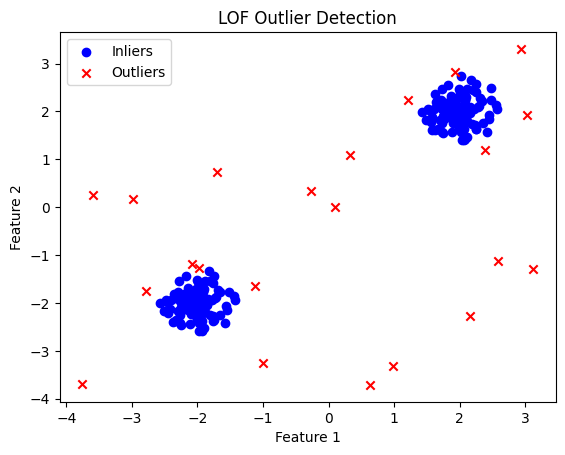

LOF scores (lower means more likely an outlier):
[-0.99994411 -1.14405944 -0.97422441 -1.29043229 -0.96406015 -0.967451
 -1.16897405 -1.17786476 -1.01083896 -1.14511932 -1.21255557 -1.05066867
 -0.96961357 -1.02846721 -0.96108146 -1.30563699 -1.01782283 -1.09341031
 -1.20053    -1.048392   -1.04273309 -0.96537973 -1.12978593 -1.04714221
 -1.1241528  -0.97795087 -0.97358493 -1.13261793 -0.98280096 -1.02069094
 -0.95891097 -1.1491003  -1.11886905 -0.99855726 -0.99357848 -1.13283666
 -1.1460512  -1.87981613 -0.95747372 -1.2240096  -0.9432555  -1.25135605
 -1.00309851 -1.10715506 -0.97725017 -0.99886729 -0.97739557 -1.09329811
 -0.99310409 -0.96318902 -1.08969429 -0.97382438 -0.94892287 -1.42556212
 -0.96379941 -1.27724298 -1.46492263 -0.94595752 -1.04083691 -1.1733885
 -1.06562769 -1.29284358 -1.32423841 -1.06358314 -0.96642636 -1.08777278
 -1.03217634 -1.24655122 -0.97201908 -1.09366836 -1.10173896 -1.12032974
 -0.98536222 -1.23121125 -1.00976101 -0.98561163 -0.97602593 -0.99192456
 -1.4

In [392]:
# Importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor
import pandas as pd

# Generating synthetic data (2D data)
np.random.seed(42)
# Generate inlier data points
X_inliers = 0.3 * np.random.randn(100, 2)
X_inliers = np.r_[X_inliers + 2, X_inliers - 2]

# Generate some outliers
X_outliers = np.random.uniform(low=-4, high=4, size=(20, 2))

# Combine the dataset
X = np.r_[X_inliers, X_outliers]

# Creating the LOF model
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
#n_neighbors=20: This parameter means the LOF algorithm is considering the 20 nearest neighbors of 
# each data point to estimate the local density around it.
#contamination=0.1: This tells the algorithm that 10% of the data points are expected to be outliers.

# Fit the model and predict the outliers
y_pred = lof.fit_predict(X)

# -1 indicates an outlier, and 1 indicates an inlier
outlier_mask = y_pred == -1
inlier_mask = y_pred == 1

# Visualizing the results
plt.scatter(X[inlier_mask, 0], X[inlier_mask, 1], c='b', marker='o', label='Inliers')
plt.scatter(X[outlier_mask, 0], X[outlier_mask, 1], c='r', marker='x', label='Outliers')
plt.title("LOF Outlier Detection")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

# Optional: Check LOF scores for each point
lof_scores = lof.negative_outlier_factor_
print("LOF scores (lower means more likely an outlier):")
print(lof_scores)


## 4. One- Class Support Vector Machines (SVM)

### How SVM works: Train the data to form a normal pattern and see if the new data set is in the pattern which is considered as normal
1. Learning "Normal" Data: Imagine you have a bunch of data points that represent normal behavior (like people doing normal activities). One-Class SVM looks at this data and tries to draw a boundary around it—kind of like drawing a circle around all the people who are behaving normally.  
2. Detecting Anomalies: Once it knows where the "normal" data is, it can start looking at new data points. If a new data point falls inside the circle, it's considered normal. If it falls outside, it's considered strange or an anomaly.

STEPS:  
1. Training the Model: You give the algorithm data that represents normal behavior. The algorithm tries to draw a boundary around this data so it can recognize it in the future.  
2. Making Predictions: When you give it new data, it checks if this data falls inside the "normal boundary." If it does, it predicts the data is normal. If it falls outside, it says the data is an anomaly.  


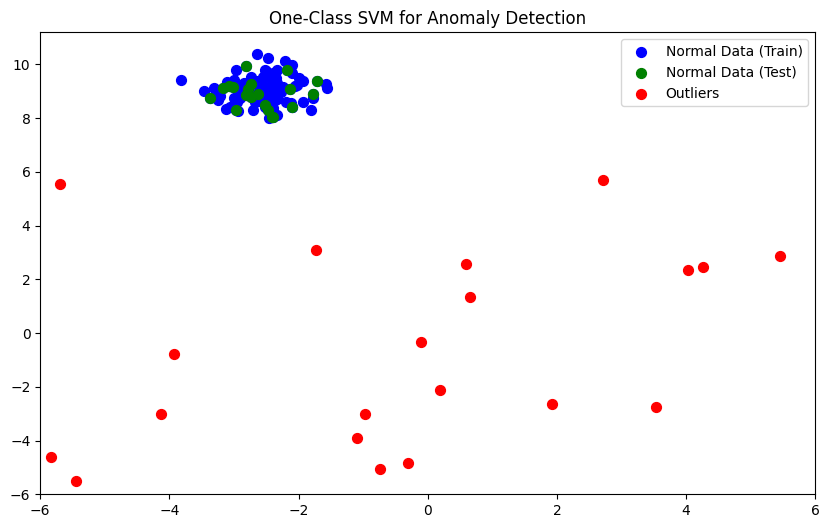

In [393]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import OneClassSVM
from sklearn.datasets import make_blobs

# Generate training data (normal data)
X_train, _ = make_blobs(n_samples=100, centers=1, cluster_std=0.5, random_state=42)

# Generate test data (some anomalies added)
X_test, _ = make_blobs(n_samples=20, centers=1, cluster_std=0.5, random_state=42)
X_outliers = np.random.uniform(low=-6, high=6, size=(20, 2))

# Create the One-Class SVM model
# nu is an upper bound on the fraction of training errors and a lower bound on the fraction of support vectors
oc_svm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.1) # kernel transfroms the data into a higher dimensional space to normal data 
# Gamma Controls how much influence each data point has on the decision boundary. High gamma means more complex boundaries;  
# low gamma means smoother boundaries. When set to 'auto', it adjusts based on the number of features in the data.  
# Nu: Controls the trade-off between allowing more outliers and keeping the decision boundary simple. A lower nu means 
# fewer outliers are tolerated; a higher nu means more outliers are allowed.


# Train the model on the normal data
oc_svm.fit(X_train)

# Predict the test data (1 = inliers, -1 = outliers)
y_pred_train = oc_svm.predict(X_train)
y_pred_test = oc_svm.predict(X_test)
y_pred_outliers = oc_svm.predict(X_outliers)

# Plotting the results
plt.figure(figsize=(10, 6))

# Plot the normal training data
plt.scatter(X_train[:, 0], X_train[:, 1], c='blue', label="Normal Data (Train)", s=50)
# Plot the normal test data
plt.scatter(X_test[:, 0], X_test[:, 1], c='green', label="Normal Data (Test)", s=50)
# Plot the outliers
plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c='red', label="Outliers", s=50)

# Create mesh grid for decision boundary visualization
xx, yy = np.meshgrid(np.linspace(-6, 6, 500), np.linspace(-6, 6, 500))
Z = oc_svm.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot decision boundary and margin
plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='black')

plt.title("One-Class SVM for Anomaly Detection")
plt.legend()
plt.show()


## 5. Principal Component Analysis(PCA)

### How PCA works  : The core idea is that anomalies are data points that don't follow the typical patterns and therefore cannot be well-reconstructed from the principal components representing the normal data.

Steps:   
1. Train PCA on Normal Data, reduce the dataset to fewer dimensions  
2. Reconstrct the Data, After training PCA, the data is transformed and then reconstructed using the top principal components. For each data point, you compute how closely it matches its original form after reconstruction.  
3. Compute Reconstruction Error: Calculate the difference between original data and the reconstructed data  
4. Set a threshold: error baove threshold are flagged as anomalies  

Disadvantes: linearity assumption

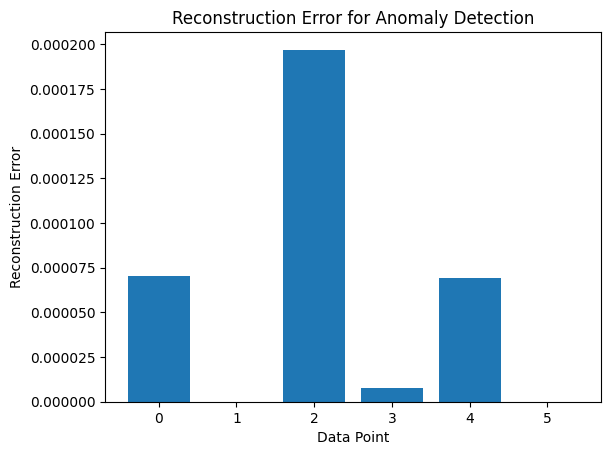

Anomalous data points: []


In [394]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Example dataset with 2D normal data and one anomaly
X = np.array([[2.5, 2.4],
              [0.5, 0.7],
              [2.2, 2.9],
              [1.9, 2.2],
              [3.1, 3.0],   # normal point
              [50, 50]])    # anomaly

# Standardize the data to mean=0 and variance=1 (important for PCA)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA to reduce to 1 principal component (assuming most data is captured in 1D)
pca = PCA(n_components=1)
X_pca = pca.fit_transform(X_scaled)

# Reconstruct the data from the principal component
X_reconstructed = pca.inverse_transform(X_pca)

# Calculate the reconstruction error (the difference between original and reconstructed data)
reconstruction_error = np.mean((X_scaled - X_reconstructed) ** 2, axis=1)

# Plot the reconstruction errors
plt.bar(range(len(reconstruction_error)), reconstruction_error)
plt.title("Reconstruction Error for Anomaly Detection")
plt.xlabel("Data Point")
plt.ylabel("Reconstruction Error")
plt.show()

# Print which points are anomalies (assuming threshold for error is 1.0)
threshold = 1.0
anomalies = np.where(reconstruction_error > threshold)
print("Anomalous data points:", anomalies[0])


## 6.K-means

### How K-means works  : You make K groups and pick initial centers . Then you get assigned to the cluster with the nearest center. After grouping , recalculate the center of each cluster by finding mean . The process repeats until the center stop moving around K-means can help you find points that don’t fit well in any cluster. After clustering the data, you can look at the distance between each point and its closest center. If a point is too far away from the center, it might be an anomaly (something unusual). 
steps: clustering the data -> Find center points -> calc the distance and reassign the points -> repeat until stable ->   Caclculate distance from points to center -> Define anaomaly threshold -> identify anomalies (e.g. furthest 10% of data points)

Centroids stop moving means that now centroids is on location A,B and then after you reassign the points and take the mean, it is still A,B


In [395]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Example Data
data = pd.DataFrame({
    'feature1': [2.5, 0.5, 2.1, 8.3, 1.2, 7.9, 8.0, 1.9, 0.6, 7.5],
    'feature2': [3.6, 2.7, 2.9, 6.8, 3.3, 7.6, 6.9, 3.1, 2.5, 7.8]
})

# Preprocess data (normalization)
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# Apply K-means
kmeans = KMeans(n_clusters=2)
kmeans.fit(data_scaled)

# Get distances from each point to its centroid
distances = np.min(kmeans.transform(data_scaled), axis=1)

# Define anomaly threshold (top 10% farthest points from centroids)
threshold = np.percentile(distances, 90)

# Flag anomalies
anomalies = data[distances > threshold]

# Output
print("Anomalies:")
print(anomalies)


Anomalies:
   feature1  feature2
0       2.5       3.6


## 7. Gaussian Mixture Model (GMM)

### How GMM works  The Gaussian Mixture Model (GMM) for anomaly detection works by modeling the data as a combination of several Gaussian (normal) distributions. After fitting the GMM to your data, the model assigns each data point a probability of belonging to one of the Gaussian distributions. Anomalies are then detected as points with very low probabilities.
Steps: Data made from multiple Gaussian -> learn about Guassians -> calc the likelihood and compare with the threshold

Drawback: Sensitive to Initialization , pre-specifying the number of components

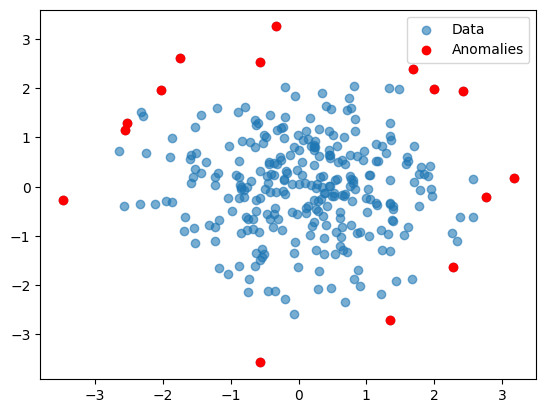

In [396]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

# Example data: 2D feature space
X = np.random.randn(300, 2)

# Fit a Gaussian Mixture Model with 2 components (can be adjusted)
gmm = GaussianMixture(n_components=2, covariance_type='full') # Assume that the data points is generated from 2 gaussian distributions
gmm.fit(X)

# Compute the log likelihood of each point
log_likelihood = gmm.score_samples(X)

# Define a threshold for anomalies (e.g., points with low log-likelihood)
threshold = np.percentile(log_likelihood, 5)  # Bottom 5% is considered anomalous

# Anomalies are points with log-likelihood below the threshold
anomalies = X[log_likelihood < threshold]

# Plot the data points and anomalies
plt.scatter(X[:, 0], X[:, 1], label='Data', alpha=0.6)
plt.scatter(anomalies[:, 0], anomalies[:, 1], color='red', label='Anomalies')
plt.legend()
plt.show()


## 8. Autoencoder

### How Autoencoder works
input -> encoder compressed to lower -dimensional representation (focus on only impmortant features) ->decoder and reconstruct -> output  
Then compare input and output and calculate MSE, outliers have larger MSE

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


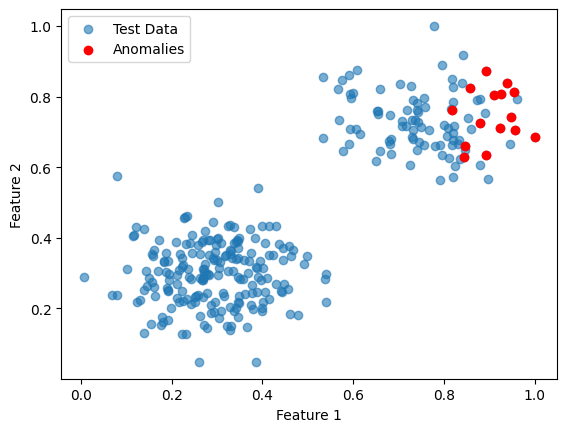

Reconstruction error threshold: 0.24568298695221738
Number of anomalies detected: 15


In [397]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from sklearn.preprocessing import MinMaxScaler

# Generate a dataset with normal and anomalous data
np.random.seed(42)
normal_data = np.random.normal(loc=0.0, scale=1.0, size=(1000, 3))  # Normal data
anomalous_data = np.random.normal(loc=5.0, scale=1.0, size=(100, 3))  # Anomalies

# Combine normal and anomalous data
X = np.concatenate([normal_data, anomalous_data], axis=0)

# Scale the data between 0 and 1
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training (only normal data) and testing (normal + anomalies)
X_train, X_test = train_test_split(X_scaled[:1000], test_size=0.2, random_state=42)
X_test = np.concatenate([X_test, X_scaled[1000:]], axis=0)

# Build an autoencoder model
input_dim = X_train.shape[1]  # Number of features
encoding_dim = 2  # Compression size

# Input layer
input_layer = Input(shape=(input_dim,))
# Encoding layer
encoded = Dense(encoding_dim, activation='relu')(input_layer)
# Decoding layer
decoded = Dense(input_dim, activation='sigmoid')(encoded)

# Build the autoencoder
autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# Train the autoencoder
history = autoencoder.fit(X_train, X_train, 
                          epochs=50, 
                          batch_size=32, 
                          validation_split=0.2, 
                          shuffle=True, 
                          verbose=0)

# Use the autoencoder to reconstruct the test data
X_test_pred = autoencoder.predict(X_test)

# Calculate the reconstruction error (mean squared error)
reconstruction_error = np.mean(np.square(X_test - X_test_pred), axis=1)

# Set a threshold for anomaly detection
threshold = np.percentile(reconstruction_error, 95)  # Choose 95th percentile

# Flag anomalies (points with high reconstruction error)
anomalies = reconstruction_error > threshold

# Visualize the results
plt.scatter(X_test[:, 0], X_test[:, 1], label='Test Data', alpha=0.6)
plt.scatter(X_test[anomalies][:, 0], X_test[anomalies][:, 1], color='red', label='Anomalies')
plt.legend()
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

# Print the threshold and number of anomalies detected
print(f"Reconstruction error threshold: {threshold}")
print(f"Number of anomalies detected: {np.sum(anomalies)}")


## 9. Hidden Markov Models (HMM)

### How HMM works  
modeling sequences where the system undergoes transitions between hidden (unobservable) states. Each hidden state generates observable data based on a probability distribution. The key components of an HMM are:  

Hidden states: Unobservable states that the system transitions between.  
Transition probabilities: Probabilities of moving from one hidden state to another.  
Emission probabilities: Probabilities of generating observable data from each hidden state.  


The Markov process in a Hidden Markov Model (HMM) refers to the assumption that the system's future state depends only on its current state and not on the sequence of previous states. This property is called the Markov property.
In an HMM, the hidden states follow this Markov process:  
The system transitions between hidden states according to certain probabilitie
The probability of transitioning to the next hidden state depends only on the current hidden state, not on the sequence of past state

quick summary: The hidden state represents whether the system is in a "normal" or "anomalous" state, but this state is unobservable (hidden) from the data we see. However, we assume that the hidden states follow a Markov process, meaning that the current hidden state (normal or anomaly) depends only on the previous hidden state.The transition probabilities determine how likely it is for the system to move from one hidden state to another (e.g., from normal to anomaly or staying in normal). The emission probabilities describe the likelihood of observing certain data (e.g., sensor readings) given the hidden state.When we calculate the likelihood of a sequence of observations based on these probabilities, a low likelihood suggests that the current data doesn't fit well with the learned normal behavior, potentially indicating an anomaly.In short, if the transition and emission probabilities result in a low likelihood for the data, it signals that an anomaly might have occurred.

In [398]:
import numpy as np
from hmmlearn import hmm

# Sample data: normal behavior with some anomalies
data = np.array([[0.1], [0.15], [0.14], [0.1], [0.12], [0.15], [10.0], [0.13], [0.11], [0.12], [0.1]])

# Create and train a GaussianHMM (continuous values)
model = hmm.GaussianHMM(n_components=2, covariance_type="diag", n_iter=1000) # n_components  = 2 because the data is either normal or is a anomolies

# Fit model on data
model.fit(data)

# Compute the log likelihood of each point
log_likelihood = model.score_samples(data)[0]

# Identify anomalies (points where log-likelihood is significantly low)
threshold = np.percentile(log_likelihood, 5)  # Define a threshold (e.g., bottom 5% likelihood)
anomalies = np.where(log_likelihood < threshold)[0]

# Display anomalies
print(f"Anomalies detected at indices: {anomalies}")


Anomalies detected at indices: []


/var/folders/ld/1rz8qh_13jz1s4wm8s6pdhgm0000gn/T/ipykernel_8086/2781025607.py:18: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  anomalies = np.where(log_likelihood < threshold)[0]


## 10. Local Correlation Integral (LCI)

### How LCI works  
The Local Correlation Integral (LCI) is a statistical method used to analyze the local structure of time-series data. It helps identify nonlinear patterns and detect anomalies by measuring the correlation between data points within a local neighborhood.The LCI provides insights into how data points are distributed in a local region of the time series, which is useful for detecting subtle changes or irregularities (potential anomalies). LCI is often used in the context of dynamical systems and chaos theory to study the local behavior of time-series data. (NOT LIMITED TO TIME SERIES)

Keywords: Correlation Integral is a measure of the probability that two points within a specific distance of each other are correlated.For LCI, we compute the correlation integral locally for each point and its neighboring points

Normal Data: In regions where the data follows the expected pattern, points will have high local correlation with their neighbors.  
Anomalous Data: In anomalous regions, the local structure breaks down, and points will have low local correlation with their neighbors, indicating potential outliers or unusual behavior.


Anomalies detected at indices: [6]


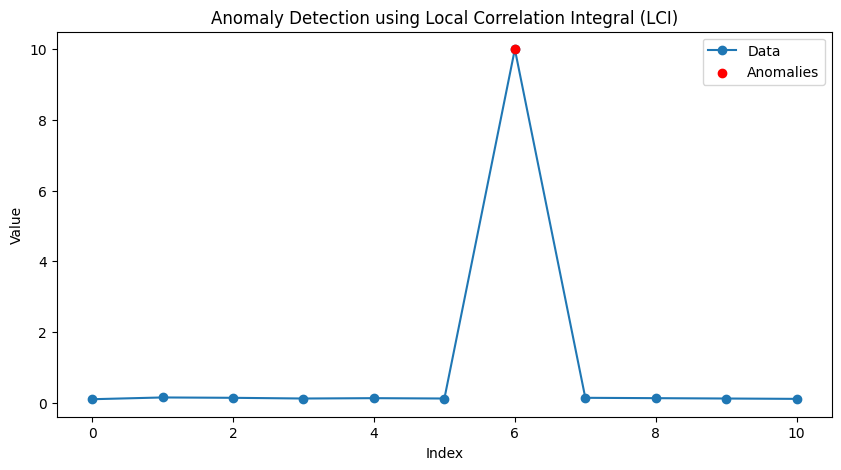

In [399]:
import numpy as np
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt

# Function to calculate the local correlation integral
def local_correlation_integral(data, radius):
    n = len(data)
    # Calculate pairwise distances between points
    distances = squareform(pdist(data.reshape(-1, 1)))

    # Count neighbors within the specified radius
    neighbor_counts = np.sum(distances < radius, axis=1)

    # Calculate Local Correlation Integral (LCI) for each point
    LCI = neighbor_counts / n  # Normalize by the total number of points
    return LCI

# Sample time-series data with a clear anomaly
data = np.array([0.1, 0.15, 0.14, 0.12, 0.13, 0.12, 10.0, 0.14, 0.13, 0.12, 0.11])

# Define a radius for the neighborhood (similar to DBSCAN's epsilon)
radius = 0.1

# Calculate the Local Correlation Integral (LCI)
lci_values = local_correlation_integral(data, radius)

# Set a threshold to detect anomalies (e.g., lowest 5% LCI values)
threshold = np.percentile(lci_values, 5)

# Detect anomalies by comparing LCI values to the threshold
anomalies = np.where(lci_values < threshold)[0]

# Output the indices of detected anomalies
print(f"Anomalies detected at indices: {anomalies}")

# Plot the data and mark anomalies
plt.figure(figsize=(10, 5))
plt.plot(data, marker='o', label='Data')
plt.scatter(anomalies, data[anomalies], color='red', label='Anomalies', zorder=5)
plt.title('Anomaly Detection using Local Correlation Integral (LCI)')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.show()


## 11. Histogram-based Outlier Detection (HBOS)

### How HBOS works  
Histogram-Based Outlier Score (HBOS) is an unsupervised anomaly detection method that works by building a histogram for each feature in the dataset and detecting outliers based on the distribution of the data in these histograms. It assumes that anomalies significantly deviate from the normal distribution of the data in terms of frequency within bins.  

e.g. Let's say we pick 100 people and record their age , find most of them are from 20-40, there are only few data points for age above 100 or below 3, they are outliers  

Histogram Construction ->  anomaly score calculation -> combining score across features(multiple dimension)

Data Categorization by Features:  
You have a dataset with various features (dimensions). HBOS works by examining each feature independently.  
For each feature, you can think of categorizing or binning the data into a histogram, where the bins represent the frequency of data points in different ranges of the feature values.  
Histogram Building:  
HBOS creates a histogram for each feature. These histograms show how the data points are distributed across different value ranges (bins).  
If a lot of data points fall into certain bins, those bins represent common behavior (normal data).  
Bins with few data points represent rare occurrences or outliers (potential anomalies).  
Identifying Anomalies:  
In HBOS, outliers are defined as data points that fall into bins with very low frequency (i.e., bins that contain very few points relative to the total).  
Anomalies: If a data point falls into a region of the histogram (bin) where the count is low (i.e., not part of the normal distribution for that feature), it is flagged as an anomaly. The outlier score is higher when the frequency of the bin is lower.  

Outlier scores: [-8.39611768 -6.97187782 -6.16029242 ...  9.42974636  0.85611763
  2.91136403]
Anomalies detected at indices: [  37   41   59   69   78  143  188  204  223  246  251  325  385  386
  409  448  451  495  549  570  644  674  706  742  752  796  823  858
  866  933  965 1000 1001 1002 1003]


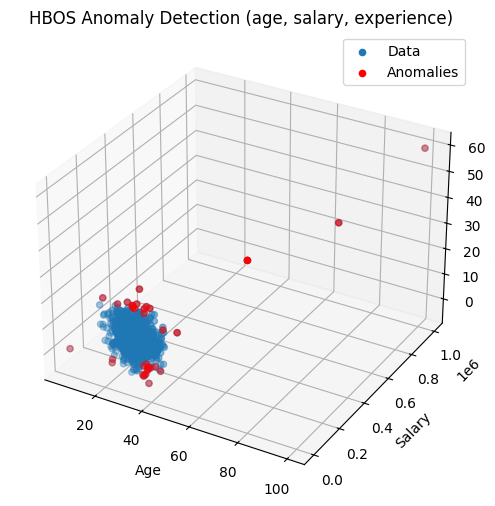

In [400]:
import numpy as np
import matplotlib.pyplot as plt
from pyod.models.hbos import HBOS
from sklearn.preprocessing import MinMaxScaler

# Generate random normal data (3 features: age, salary, experience)
np.random.seed(42)
X_normal = np.random.normal(loc=[30, 50000, 10], scale=[5, 10000, 5], size=(1000, 3))  # 1000 normal points

# Add some anomalies (outliers) - points far from the normal data
X_anomalies = np.array([[90, 500000, 50], [100, 1000000, 60], [5, 2000, 1], [80, 1000, 55]])

# Combine normal data and anomalies
X = np.vstack([X_normal, X_anomalies])

# Scale the data for HBOS (HBOS works better on normalized data)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Initialize the HBOS model
hbos = HBOS()

# Fit the model to the dataset
hbos.fit(X_scaled)

# Get the outlier scores for each data point
outlier_scores = hbos.decision_function(X_scaled)

# Detect anomalies (outliers) using a percentile threshold
threshold = np.percentile(outlier_scores, 95)  # Top 5% are considered anomalies
anomalies = np.where(outlier_scores > threshold)[0]

# Display results
print(f"Outlier scores: {outlier_scores}")
print(f"Anomalies detected at indices: {anomalies}")

# Plot the dataset and highlight anomalies in one of the 3D projections (age vs salary)
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], label='Data')
ax.scatter(X[anomalies, 0], X[anomalies, 1], X[anomalies, 2], color='red', label='Anomalies', zorder=5)
ax.set_title('HBOS Anomaly Detection (age, salary, experience)')
ax.set_xlabel('Age')
ax.set_ylabel('Salary')
ax.set_zlabel('Experience')
plt.legend()
plt.show()


## 12. Angle-based Outlier Detection (ABOD) (Choice)

### How ABOD works  
ABOD calculates the variance of angles formed between a data point and pairs of its neighboring data points.  
The intuition behind this method is that for normal points, the angles formed between the point and its neighbors tend to be small and similar. For outliers, the angles vary more widely because outliers are more "isolated" or differently positioned relative to the other points.  

Steps:  
For each data point, ABOD calculates the angles formed between that point and pairs of other points (neighbors) in the dataset.  
It then computes the variance of these angles.  
Data points that have a high variance in angles are considered anomalies because they behave differently compared to most of the data points.  

Outlier scores: [-2.40910334e-01 -2.63494605e+00 -1.21499515e-02 ... -1.07211636e-03
 -2.97074456e-04 -1.29357262e-04]
Anomalies detected at indices: (array([   2,   14,   41,   94,  212,  220,  230,  232,  269,  318,  323,
        391,  501,  510,  567,  576,  579,  603,  648,  743,  796,  927,
        945,  956,  970,  974, 1000, 1001, 1002, 1003, 1004]),)


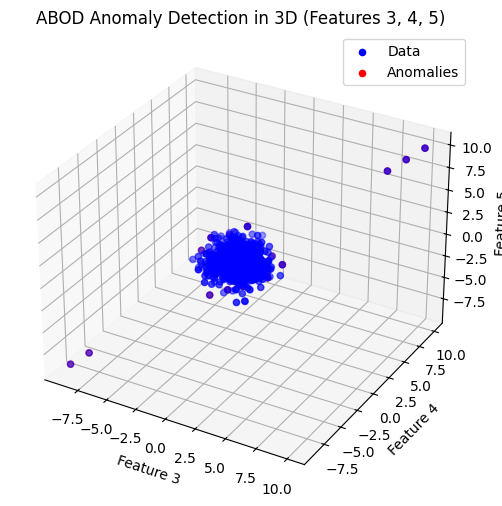

In [401]:
import numpy as np
import matplotlib.pyplot as plt
from pyod.models.abod import ABOD
from mpl_toolkits.mplot3d import Axes3D

# Generate random normal data (5 features)
np.random.seed(42)
X_normal = np.random.normal(0, 1, (1000, 5))  # 1000 normal points in 5 dimensions

# Add some anomalies (outliers)
X_anomalies = np.array([[8, 8, 8, 8, 8], [9, 9, 9, 9, 9], [10, 10, 10, 10, 10],
                        [-8, -8, -8, -8, -8], [-9, -9, -9, -9, -9]])

# Combine normal data and anomalies
X = np.vstack([X_normal, X_anomalies])

# Initialize the ABOD model with a slightly higher contamination rate
abod = ABOD(contamination=0.03)  # Increase contamination to 3% of expected outliers

# Fit the model to the dataset
abod.fit(X)

# Get the outlier scores for each data point
outlier_scores = abod.decision_function(X)

# Detect anomalies (outliers)
anomalies = abod.labels_  # binary labels (0: normal, 1: anomaly)

# Display results
print(f"Outlier scores: {outlier_scores}")
print(f"Anomalies detected at indices: {np.where(anomalies == 1)}")

# Plot the dataset in 3D and highlight anomalies using a different projection (features 3, 4, 5)
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 2], X[:, 3], X[:, 4], label='Data', c='blue')
ax.scatter(X[anomalies == 1, 2], X[anomalies == 1, 3], X[anomalies == 1, 4], color='red', label='Anomalies', zorder=5)
ax.set_title('ABOD Anomaly Detection in 3D (Features 3, 4, 5)')
ax.set_xlabel('Feature 3')
ax.set_ylabel('Feature 4')
ax.set_zlabel('Feature 5')
plt.legend()
plt.show()


## 13. Clustering -Based Local Outlier Factor (CBLOF)

### How CBLOF works  
lustering-Based Local Outlier Factor (CBLOF) is an anomaly detection algorithm that identifies outliers based on the distribution of data across clusters. CBLOF assumes that most data points belong to large, dense clusters, while outliers are either points that fall in small, sparse clusters or far away from dense clusters.  

Here’s a breakdown of how CBLOF works:  

Steps in CBLOF:  
Clustering: The data is first grouped into clusters using a clustering algorithm like K-means, DBSCAN, or others. These clusters represent regions where data points are more densely populated.  
Labeling Clusters:  
Large Clusters: Clusters with a high number of data points are labeled as normal clusters.  
Small Clusters: Clusters with very few data points are labeled as outlier clusters.  
Outlier Score Calculation: For each data point, CBLOF computes an outlier score based on the cluster it belongs to:  
Points in large clusters receive lower scores because they are considered normal.  
Points in small clusters receive higher scores, indicating they are potential outliers.  
Additionally, a point’s distance to the center of its cluster (or to a nearby large cluster) is also factored into the score, with farther points being more likely to be outliers.  
Detection: Points with the highest CBLOF scores are flagged as outliers.  

In [402]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from pyod.models.cblof import CBLOF  # Ensure pyod is installed correctly
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN

# 1. Generate synthetic multidimensional data (5-dimensional data)
n_samples = 500
n_features = 5  # Working with 5 dimensions
X, y = make_blobs(n_samples=n_samples, centers=4, n_features=n_features, cluster_std=1.0, random_state=42)

# Standardize the data
X = StandardScaler().fit_transform(X)

# 2. Apply DBSCAN for outlier detection in 5D (for comparison)
dbscan = DBSCAN(eps=0.5, min_samples=10)
dbscan_labels = dbscan.fit_predict(X)

# 3. Apply CBLOF with adjusted n_clusters and optional PCA for dimensionality reduction
try:
    # Reduce dimensionality to 2D for visualization using PCA
    X_reduced = PCA(n_components=2).fit_transform(X)  # Reducing the data to 2 dimensions

    # Apply CBLOF after reducing the dimensionality
    cblof = CBLOF(n_clusters=4, alpha=0.9, use_weights=False)  # Use Agglomerative Clustering
    cblof.fit(X_reduced)

    cblof_labels = cblof.labels_  # Binary labels (0 for normal, 1 for outliers)
    cblof_scores = cblof.decision_scores_  # Raw outlier scores

    # 4. Plotting the 2D projection of multidimensional data for DBSCAN and CBLOF
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # DBSCAN plot
    ax1.scatter(X_reduced[:, 0], X_reduced[:, 1], c=dbscan_labels, cmap='rainbow', edgecolor='k')
    ax1.set_title("DBSCAN Clustering & Outlier Detection (2D Projection)")

    # CBLOF plot
    ax2.scatter(X_reduced[:, 0], X_reduced[:, 1], c=cblof_labels, cmap='rainbow', edgecolor='k')
    ax2.set_title("CBLOF Clustering & Outlier Detection (2D Projection)")

    plt.show()

    # 5. Display CBLOF outlier scores
    print("CBLOF Outlier Scores (first 10 points):")
    print(cblof_scores[:10])

except ValueError as e:
    print(f"Error during CBLOF clustering: {e}")
    print("Consider adjusting the number of clusters or the clustering method.")


Error during CBLOF clustering: Could not form valid cluster separation. Please change n_clusters or change clustering method
Consider adjusting the number of clusters or the clustering method.


## 14. Minimum Covariance Determinant (MCD)

 ### How MCD works  
 Robust Estimation:  
The MCD algorithm searches for the subset of data points whose covariance matrix has the lowest determinant, implying that it represents the core, tightly clustered data.  
It computes robust estimates for the mean and covariance of this subset, which is less influenced by outliers.  
Outlier Detection:  
Once the robust mean and covariance are estimated, Mahalanobis distances can be computed for each data point. Points with large Mahalanobis distances from the robustly estimated mean are considered potential outliers.  
Mahalanobis Distance: It is a distance metric that accounts for correlations between variables and is useful for identifying outliers in multivariate data. A large Mahalanobis distance suggests that a point is far from the core of the data, indicating a potential anomaly  

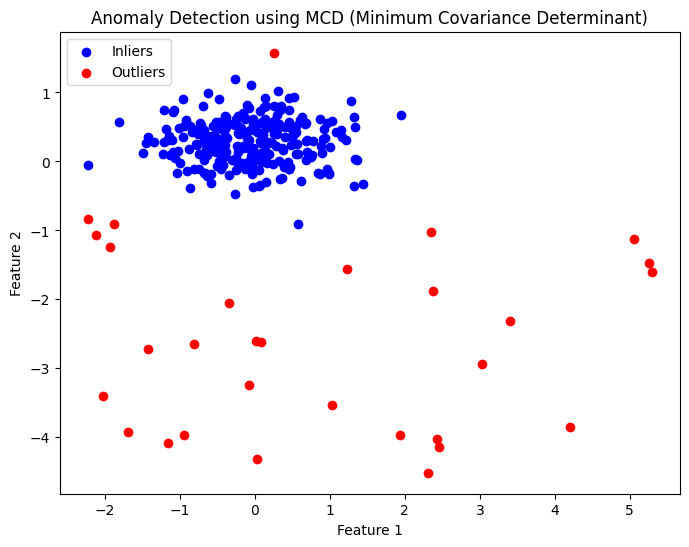

Mahalanobis Distances (first 10 points):
[7.04536452 2.08853466 0.57253089 2.4104849  0.16866286 0.30408924
 4.27983581 9.82258617 1.18765038 0.59755289]

Outlier locations (coordinates):
[[ 0.25442804  1.57666532]
 [ 3.40868873 -2.30954898]
 [-1.15409121 -4.0764958 ]
 [-1.92991612 -1.24171984]
 [ 2.37188775 -1.87280938]
 [-2.22697785 -0.82765419]
 [ 4.20442651 -3.85158955]
 [-0.94965781 -3.96708551]
 [ 0.02011136 -2.60453798]
 [ 1.03175137 -3.53669044]
 [ 2.45695146 -4.14236018]
 [-0.07572376 -3.23678916]
 [ 1.22286531 -1.56504189]
 [-0.80826249 -2.64653779]
 [ 2.30296429 -4.51375437]
 [ 2.42282386 -4.01849913]
 [-1.87471694 -0.91157529]
 [ 5.25953058 -1.47235091]
 [ 0.02305453 -4.30929675]
 [ 3.03033475 -2.94224484]
 [-1.4232783  -2.72260822]
 [-2.11762466 -1.06950432]
 [-0.34003307 -2.05462889]
 [ 0.0792782  -2.62325233]
 [ 1.94090256 -3.96129788]
 [ 5.29084238 -1.60513029]
 [ 5.05250861 -1.12735509]
 [ 2.34641879 -1.01939417]
 [-1.68902198 -3.91687749]
 [-2.03176176 -3.40057141]]


In [403]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.covariance import EllipticEnvelope
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

# 1. Generate synthetic multivariate data (with outliers)
n_samples = 300
n_outliers = 30
X, y = make_blobs(n_samples=n_samples - n_outliers, centers=1, cluster_std=1.0, random_state=42)

# Add some outliers
rng = np.random.RandomState(42)
outliers = rng.uniform(low=-6, high=6, size=(n_outliers, 2))
X = np.vstack([X, outliers])

# Standardize the data
X = StandardScaler().fit_transform(X)

# 2. Apply the Minimum Covariance Determinant (MCD) for anomaly detection
mcd = EllipticEnvelope(contamination=0.1)  # Set contamination to 10% for outlier detection
mcd.fit(X)

# 3. Predict outliers (-1 for outliers, 1 for inliers)
mcd_predictions = mcd.predict(X)

# 4. Calculate Mahalanobis distances for each point
mcd_mahalanobis_distances = mcd.mahalanobis(X)

# 5. Plotting the data, marking the outliers
plt.figure(figsize=(8, 6))

# Inliers (non-outliers)
plt.scatter(X[mcd_predictions == 1, 0], X[mcd_predictions == 1, 1], c='b', label='Inliers')

# Outliers
plt.scatter(X[mcd_predictions == -1, 0], X[mcd_predictions == -1, 1], c='r', label='Outliers')

plt.legend(loc="upper left")
plt.title("Anomaly Detection using MCD (Minimum Covariance Determinant)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

# 6. Display the Mahalanobis distances of the first 10 points
print("Mahalanobis Distances (first 10 points):")
print(mcd_mahalanobis_distances[:10])

# 7. Print the locations (coordinates) of the detected outliers
outlier_locations = X[mcd_predictions == -1]
print("\nOutlier locations (coordinates):")
print(outlier_locations)


## 15. Stochastic Outlier Selection (SOS)

### How SOS works  
Pairwise Similarities: SOS calculates pairwise similarities between each pair of data points using a Gaussian kernel. The similarity between two points decreases as the distance between them increases.  
Probabilistic Approach: For each data point, SOS computes the probability that it "selects" other points as its neighbors. The algorithm is designed in such a way that outliers will have a low probability of being selected as neighbors by most other points.  
Outlier Score: The final outlier score for each data point is computed based on how often the point is selected as a neighbor by other points. Points that are rarely selected by others are flagged as potential outliers.  

SOS ROC:0.4567, precision @ rank n:0.3
y_test_pred: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1]


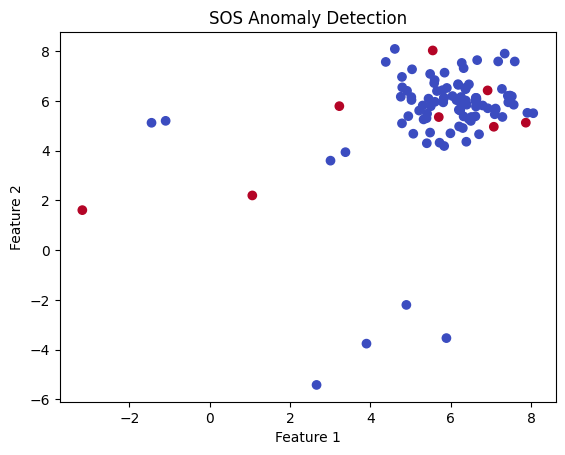

In [404]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from pyod.models.sos import SOS
from pyod.utils.data import generate_data
from pyod.utils.data import evaluate_print

# Generate sample data with outliers
X_train, X_test, y_train, y_test = generate_data(n_train=200, n_test=100, n_features=2, contamination=0.1, random_state=42)

# Initialize SOS detector
sos = SOS()

# Fit the model on the training data
sos.fit(X_train)

# Predict outliers on test data
y_test_scores = sos.decision_function(X_test)  # outlier scores
y_test_pred = sos.predict(X_test)  # binary labels (0: inlier, 1: outlier)

# Evaluate the performance of the detector
evaluate_print('SOS', y_test, y_test_scores)

# Optionally print y_test_pred to check
print("y_test_pred:", y_test_pred)

# Visualize the outliers
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test_pred, cmap='coolwarm')
plt.title("SOS Anomaly Detection")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()


## 16. Spectral Clustering for Anomaly Detection (SpectralResidual)

### How Spectral Residual works  
Spectral clustering is a graph-based method that uses eigenvalue decomposition of a similarity matrix to cluster data in a lower-dimensional space.  In anomaly detection, data points that don't fit well into any cluster or form small, isolated clusters are considered anomalies. This method excels at detecting anomalies in complex datasets with non-linear relationships, as it captures local and global structure in the data.

Key Steps:  
Build a similarity matrix to represent relationships between data points.  
Compute the Laplacian matrix and perform eigenvalue decomposition.  
Cluster data in the reduced-dimensional space (using k-means or another clustering method).  
Detect anomalies by identifying points that don’t cluster well or belong to small clusters.  

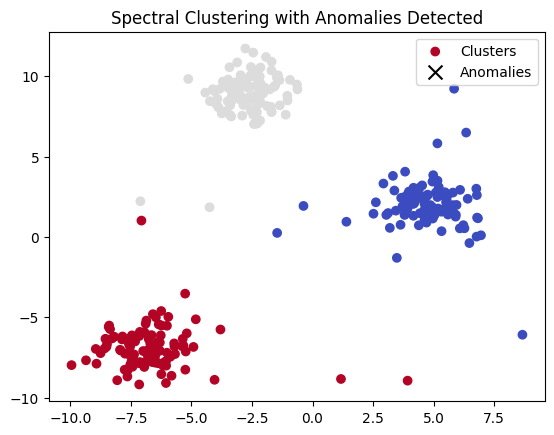

In [405]:
# Import necessary libraries
import numpy as np
from sklearn.cluster import SpectralClustering
from sklearn.metrics.pairwise import rbf_kernel
import matplotlib.pyplot as plt

# Generate synthetic data
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=300, centers=3, random_state=42, cluster_std=1.0)

# Introduce some outliers
outliers = np.random.uniform(low=-10, high=10, size=(15, 2))
X = np.vstack([X, outliers])

# Apply Spectral Clustering
similarity_matrix = rbf_kernel(X, gamma=0.1)  # RBF kernel to build similarity matrix
spectral = SpectralClustering(n_clusters=3, affinity='precomputed')
y_pred = spectral.fit_predict(similarity_matrix)

# Detect anomalies (points that do not fit well into clusters)
# Outliers will likely be assigned to different/small clusters
outlier_indices = np.where(np.bincount(y_pred) <= 5)[0]  # small clusters as outliers
anomalies = np.where(np.isin(y_pred, outlier_indices))[0]

# Visualize the clusters and anomalies
plt.scatter(X[:, 0], X[:, 1], c=y_pred, cmap='coolwarm', label='Clusters')
plt.scatter(X[anomalies, 0], X[anomalies, 1], color='black', marker='x', label='Anomalies', s=100)
plt.title('Spectral Clustering with Anomalies Detected')
plt.legend()
plt.show()


## 17. Feature Bagging 

### How Feature Bagging works  
Randomly select subsets of features from the original dataset.  
Train individual anomaly detection models on each subset of features.  
Aggregate the results of the models to make a final decision about whether a data point is an anomaly or not. Typically, this involves majority voting or averaging outlier scores.  

Feature Bagging with KNN ROC:1.0, precision @ rank n:1.0


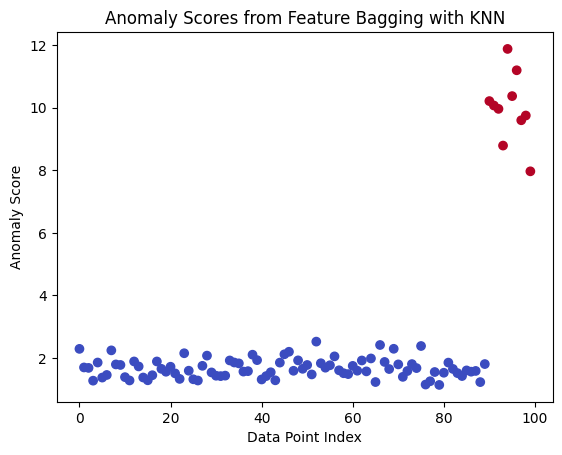

In [406]:
# Install pyod if not installed
# !pip install pyod

# Import necessary libraries
import numpy as np
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.knn import KNN  # K-Nearest Neighbors as base model for anomaly detection
from pyod.utils.data import generate_data
from pyod.utils.data import evaluate_print
import matplotlib.pyplot as plt

# Generate sample data with outliers
X_train, X_test, y_train, y_test = generate_data(n_train=200, n_test=100, n_features=10, contamination=0.1, random_state=42)

# Initialize Feature Bagging model with KNN as the base detector
feature_bagging = FeatureBagging(base_estimator=KNN(), n_estimators=10, random_state=42)

# Fit the model on the training data
feature_bagging.fit(X_train)

# Predict outliers on test data
y_test_scores = feature_bagging.decision_function(X_test)  # outlier scores
y_test_pred = feature_bagging.predict(X_test)  # binary labels (0: inlier, 1: outlier)

# Evaluate the performance of the detector
evaluate_print('Feature Bagging with KNN', y_test, y_test_scores)

# Visualize the anomaly scores
plt.scatter(range(len(y_test_scores)), y_test_scores, c=y_test_pred, cmap='coolwarm')
plt.title('Anomaly Scores from Feature Bagging with KNN')
plt.xlabel('Data Point Index')
plt.ylabel('Anomaly Score')
plt.show()


## 18. Average KNN (Choice)

### How Agerage KNN works  
Average KNN is a variant of the K-Nearest Neighbors (KNN) algorithm used for anomaly detection. In the traditional KNN algorithm, each data point is compared with its k nearest neighbors, and the distance to these neighbors is used to determine whether the point is an anomaly. In average KNN, instead of using just the distance to the furthest neighbor (like in traditional KNN), we calculate the average distance between a point and all of its k nearest neighbors. This average distance is used as the anomaly score.

If a point has a large average distance to its neighbors, it's likely to be an anomaly (since it's far from other points in the dataset).
If a point has a small average distance to its neighbors, it's likely to be an inlier (since it's close to other points in the dataset).

Average KNN ROC:1.0, precision @ rank n:1.0


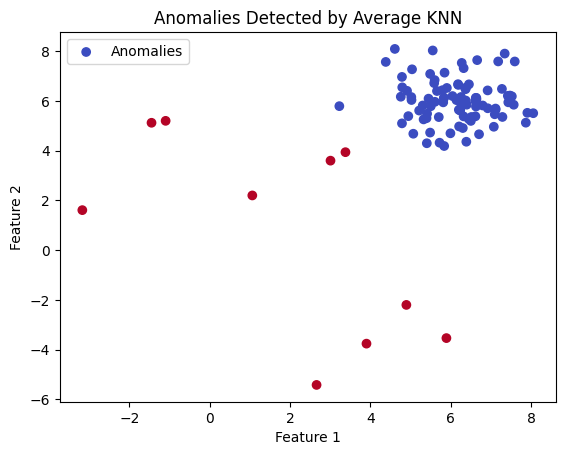

In [407]:
# Install pyod if not installed
# !pip install pyod

# Import necessary libraries
import numpy as np
from pyod.models.knn import KNN  # K-Nearest Neighbors for anomaly detection
from pyod.utils.data import generate_data
from pyod.utils.data import evaluate_print
import matplotlib.pyplot as plt

# Generate sample data with outliers
X_train, X_test, y_train, y_test = generate_data(n_train=200, n_test=100, n_features=2, contamination=0.1, random_state=42)

# Initialize the KNN model with 'mean' method for Average KNN
knn = KNN(n_neighbors=5, method='mean')  # method='mean' uses average distance for anomaly detection

# Fit the model on the training data
knn.fit(X_train)

# Predict outliers on the test data
y_test_scores = knn.decision_function(X_test)  # Anomaly scores based on average distance
y_test_pred = knn.predict(X_test)  # Binary labels (0: inlier, 1: outlier)

# Evaluate the model
evaluate_print('Average KNN', y_test, y_test_scores)

# Visualize the results (works for 2D data)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test_pred, cmap='coolwarm', label='Anomalies')
plt.title('Anomalies Detected by Average KNN')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()


## 19. Connectivity-based Outlier Factor (COF)

### How COF works  
Select Neighbors: For each point, find its k nearest neighbors.  
Compute Connectivity: Measure the connectivity between the point and its neighbors.  
Calculate COF: Assign an outlier score (COF) based on how connected the point is to its neighbors. A high COF indicates an outlier, while a low COF indicates a normal point.  

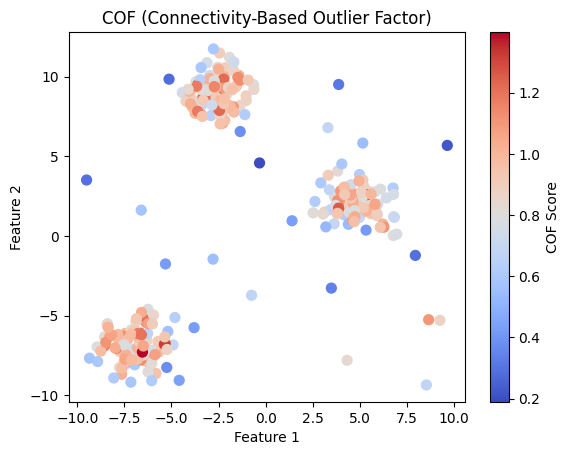

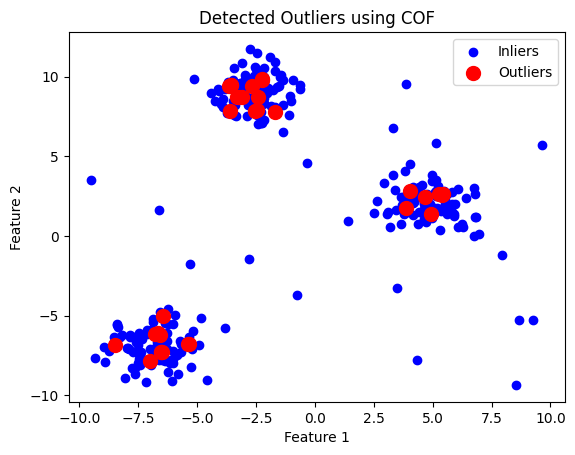

In [408]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

# Define COF function
def calculate_cof(X, k=5):
    # Find k nearest neighbors
    nbrs = NearestNeighbors(n_neighbors=k+1).fit(X)
    distances, indices = nbrs.kneighbors(X)
    
    # Remove self-distance (distance to itself is always 0)
    distances = distances[:, 1:]
    indices = indices[:, 1:]
    
    # Calculate the average connectivity for each point
    average_distances = np.mean(distances, axis=1)
    
    # Compute the connectivity-based outlier factor (COF)
    cof_scores = []
    for i, point in enumerate(X):
        neighbor_indices = indices[i]
        neighbor_distances = np.mean(distances[neighbor_indices], axis=1)
        cof_score = np.mean(neighbor_distances) / average_distances[i]
        cof_scores.append(cof_score)
    
    return np.array(cof_scores)

# Generate synthetic data
from sklearn.datasets import make_blobs

X, _ = make_blobs(n_samples=300, centers=3, cluster_std=1.0, random_state=42)
# Add some outliers
outliers = np.random.uniform(low=-10, high=10, size=(20, 2))
X = np.vstack([X, outliers])

# Calculate COF scores
cof_scores = calculate_cof(X, k=5)

# Visualize COF scores (higher scores = more likely outliers)
plt.scatter(X[:, 0], X[:, 1], c=cof_scores, cmap='coolwarm', s=50)
plt.colorbar(label='COF Score')
plt.title('COF (Connectivity-Based Outlier Factor)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

# Threshold: Let's label the top 10% of points with the highest COF as outliers
threshold = np.percentile(cof_scores, 90)
outliers = X[cof_scores >= threshold]

# Visualize detected outliers
plt.scatter(X[:, 0], X[:, 1], color='blue', label='Inliers')
plt.scatter(outliers[:, 0], outliers[:, 1], color='red', label='Outliers', s=100)
plt.title('Detected Outliers using COF')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()


## 20 Variational Autoencoder (VAE)

Epoch 1, Loss: 10.1928
Epoch 2, Loss: 9.4635
Epoch 3, Loss: 9.3959
Epoch 4, Loss: 9.0478
Epoch 5, Loss: 8.8300
Epoch 6, Loss: 8.7586
Epoch 7, Loss: 8.6442
Epoch 8, Loss: 8.3880
Epoch 9, Loss: 7.9145
Epoch 10, Loss: 8.3789
Epoch 11, Loss: 7.8847
Epoch 12, Loss: 7.8814
Epoch 13, Loss: 7.9030
Epoch 14, Loss: 7.4578
Epoch 15, Loss: 7.2913
Epoch 16, Loss: 6.7203
Epoch 17, Loss: 6.1382
Epoch 18, Loss: 6.9044
Epoch 19, Loss: 6.2656
Epoch 20, Loss: 6.5951
Epoch 21, Loss: 5.7736
Epoch 22, Loss: 5.5439
Epoch 23, Loss: 5.6056
Epoch 24, Loss: 4.5470
Epoch 25, Loss: 4.7049
Epoch 26, Loss: 5.2168
Epoch 27, Loss: 4.9641
Epoch 28, Loss: 5.7269
Epoch 29, Loss: 4.8261
Epoch 30, Loss: 5.0921
Epoch 31, Loss: 5.0075
Epoch 32, Loss: 4.7126
Epoch 33, Loss: 4.7240
Epoch 34, Loss: 4.5611
Epoch 35, Loss: 4.2888
Epoch 36, Loss: 4.4652
Epoch 37, Loss: 4.6906
Epoch 38, Loss: 4.6232
Epoch 39, Loss: 4.1909
Epoch 40, Loss: 4.5854
Epoch 41, Loss: 4.8321
Epoch 42, Loss: 4.5769
Epoch 43, Loss: 4.5503
Epoch 44, Loss: 4.5

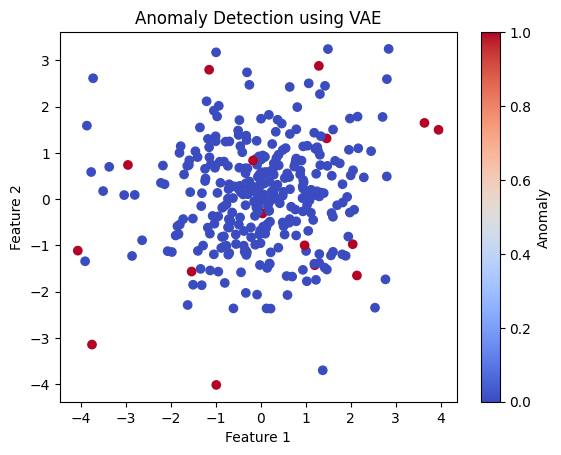

In [409]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# Step 1: Define the VAE architecture

latent_dim = 2  # Number of latent space dimensions

# Encoder: maps input to latent distribution
def build_encoder(input_shape):
    inputs = layers.Input(shape=(input_shape,))  # Correct input shape as a tuple
    x = layers.Dense(16, activation='relu')(inputs)
    x = layers.Dense(8, activation='relu')(x)
    
    z_mean = layers.Dense(latent_dim)(x)
    z_log_var = layers.Dense(latent_dim)(x)
    
    return tf.keras.Model(inputs, [z_mean, z_log_var])

# Sampling layer: sample from the latent space using z_mean and z_log_var
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = tf.random.normal(shape=(tf.shape(z_mean)[0], latent_dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Decoder: maps latent vector back to reconstructed input
def build_decoder(output_shape):
    latent_inputs = layers.Input(shape=(latent_dim,))
    x = layers.Dense(8, activation='relu')(latent_inputs)
    x = layers.Dense(16, activation='relu')(x)
    outputs = layers.Dense(output_shape)(x)
    
    return tf.keras.Model(latent_inputs, outputs)

# Step 2: Define the VAE model

class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.sampling = Sampling()

    def call(self, inputs):
        z_mean, z_log_var = self.encoder(inputs)
        z = self.sampling([z_mean, z_log_var])
        reconstructed = self.decoder(z)
        return reconstructed

    def compute_loss(self, x, reconstructed, z_mean, z_log_var):
        reconstruction_loss = tf.reduce_mean(tf.reduce_sum(tf.square(x - reconstructed), axis=-1))
        kl_loss = -0.5 * tf.reduce_mean(tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1))
        return reconstruction_loss + kl_loss

# Step 3: Generate synthetic data

def generate_data(n_samples=1000):
    normal_data = np.random.normal(loc=0.0, scale=1.0, size=(n_samples, 2))
    anomalies = np.random.uniform(low=-4, high=4, size=(int(0.1 * n_samples), 2))
    X = np.vstack([normal_data, anomalies])
    y = np.hstack([np.zeros(n_samples), np.ones(int(0.1 * n_samples))])  # 0: normal, 1: anomaly
    return X, y

X_train, y_train = generate_data(1000)
X_test, y_test = generate_data(300)

# Step 4: Train the VAE

input_shape = X_train.shape[1]  # Input shape should be 2 since we have 2 features
encoder = build_encoder(input_shape)
decoder = build_decoder(input_shape)

vae = VAE(encoder, decoder)
optimizer = tf.keras.optimizers.Adam()

# Training loop
epochs = 50
batch_size = 32

for epoch in range(epochs):
    for i in range(0, X_train.shape[0], batch_size):
        x_batch = X_train[i:i + batch_size]
        with tf.GradientTape() as tape:
            z_mean, z_log_var = encoder(x_batch)
            reconstructed = vae(x_batch)
            loss = vae.compute_loss(x_batch, reconstructed, z_mean, z_log_var)
        gradients = tape.gradient(loss, vae.trainable_variables)
        optimizer.apply_gradients(zip(gradients, vae.trainable_variables))
    
    print(f'Epoch {epoch+1}, Loss: {loss.numpy():.4f}')

# Step 5: Anomaly Detection using Reconstruction Error

def compute_reconstruction_error(model, X):
    reconstructed = model(X)
    reconstruction_error = np.mean(np.square(X - reconstructed), axis=1)
    return reconstruction_error

# Calculate reconstruction errors for the test set
reconstruction_errors = compute_reconstruction_error(vae, X_test)

# Set a threshold for anomaly detection
threshold = np.percentile(reconstruction_errors, 95)
anomalies = reconstruction_errors > threshold

# Step 6: Visualize the results

plt.scatter(X_test[:, 0], X_test[:, 1], c=anomalies, cmap='coolwarm')
plt.title('Anomaly Detection using VAE')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Anomaly')
plt.show()
